<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dimensionality-Reduction" data-toc-modified-id="Dimensionality-Reduction-1">Dimensionality Reduction</a></span></li><li><span><a href="#Create-simulated-dataset" data-toc-modified-id="Create-simulated-dataset-2">Create simulated dataset</a></span></li><li><span><a href="#Load-post-processed-simulated-data" data-toc-modified-id="Load-post-processed-simulated-data-3">Load post-processed simulated data</a></span></li><li><span><a href="#Visualize-our-data" data-toc-modified-id="Visualize-our-data-4">Visualize our data</a></span></li></ul></div>

# Dimensionality Reduction

Not really an fMRI analysis technique, per se

Averaging: increase signal by taking a summary statistic

PCA: Reduce data (e.g., 100 voxels) into several components (e.g., 20 components) that explain most variability of the data. 

Preprocessing, compression, denoising, visualization

ICA: Components must be statistically independent, not just uncorrelated. You can think of it as trying to "unmix" your data. While PCA tries to reduce your data into less variables while preserving the richness of your data, ICA tries to deduce the separate signals that mixed together to produce your observed data.

Correlated refers to whether a change in one component is associated with a change in another component. Independent means that if you have information about one component, that would be entirely uninformative to predicting information about any other component. Independent components are uncorrelated, but not all uncorrelated components are independent.

LDA: Think of LDA as supervised PCA. You need to provide not only the data but also the classes associated with your separate data points. LDA then tries to create a reduced set of components that best separates the data based on the provided classes.

Factor analysis: Reduce data into several "latent variables". E.g., reduce very long personality test responses into a small number of personality traits. More interpretable.

Nonlinear dimensionality reduction: All of the above methods assume that the components are linear (e.g., the green arrow in above plot is not a straight line).

One example of PCA for data visualization is with the EduCortex webtool (https://paulscotti.github.io/educortex) which overlays PCA components on a human brain in order to visualize where different high-level features of the brain.

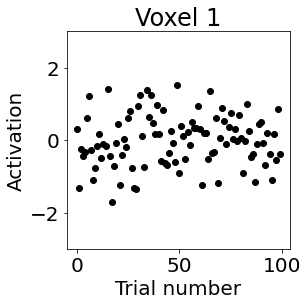

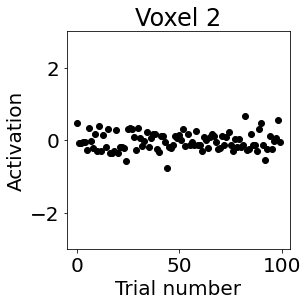

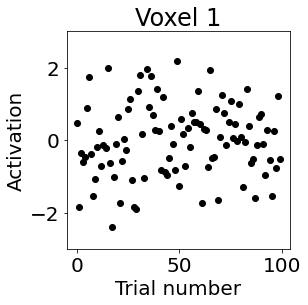

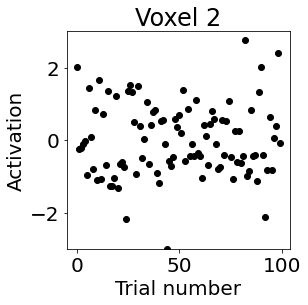

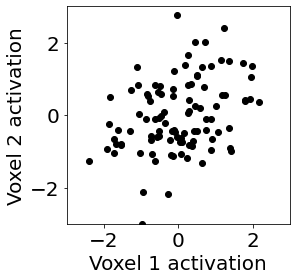

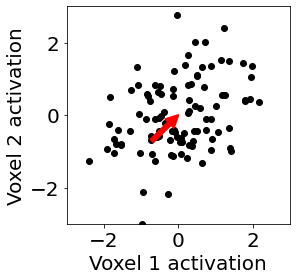

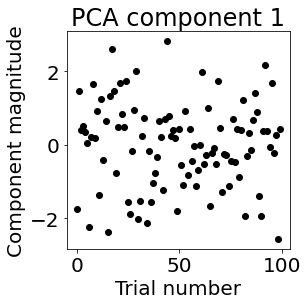

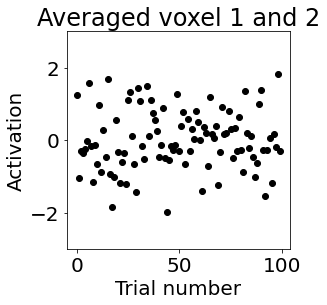

As you can see, we are characterizing every voxel according to two dimensions: scariness and funniness. However, these two dimensions are clearly correlated. If scariness is high then funniness is usually also high. What if we wanted a simpler dependent variable that is characterized by only a single dimension?


In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# change default plotting
plt.rcParams.update({'font.size': 20, 'figure.figsize': (4,4)})

# create simulated data w/ rng seed so results are replicable
np.random.seed(3)
activations = np.random.randn(100, 2) @ np.random.rand(2, 2)

# plot voxel 1
plt.scatter(np.arange(len(activations[:,0])),activations[:,0],c='k')
plt.xlabel('Trial number')
plt.ylabel('Activation')
plt.ylim([-3,3])
plt.title("Voxel 1")
plt.show()

# plot voxel 2
plt.scatter(np.arange(len(activations[:,1])),activations[:,1],c='k')
plt.xlabel('Trial number')
plt.ylabel('Activation')
plt.ylim([-3,3])
plt.title("Voxel 2")
plt.show()

# Normalize data
# PCA works to identify components that explain maximal variance--if some features in your data already have larger variance, this will lead to problems. Normalization ensures this does not happen.
activations = (activations - np.mean(activations,axis=0)) / np.std(activations,axis=0)

# plot voxel 1
plt.scatter(np.arange(len(activations[:,0])),activations[:,0],c='k')
plt.xlabel('Trial number')
plt.ylabel('Activation')
plt.ylim([-3,3])
plt.title("Voxel 1")
plt.show()

# plot voxel 2
plt.scatter(np.arange(len(activations[:,1])),activations[:,1],c='k')
plt.xlabel('Trial number')
plt.ylabel('Activation')
plt.ylim([-3,3])
plt.title("Voxel 2")
plt.show()

# plot voxels 1 and 2
plt.scatter(activations[:,0],activations[:,1],c='k')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('Voxel 1 activation')
plt.ylabel('Voxel 2 activation')
plt.show()

# perform PCA
n_components = 1
model = PCA(n_components = n_components)
model.fit(activations)
components = model.components_.T

# plot first component
plt.scatter(activations[:,0],activations[:,1],c='k')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('Voxel 1 activation')
plt.ylabel('Voxel 2 activation')
plt.annotate('', [0,0], components, arrowprops=dict(lw=2,color='r'))
plt.show()

# plot voxel 1 and 2 activations (2 dim.) represented as component magnitude (1 dim.)
restored=model.transform(activations)
plt.scatter(np.arange(len(restored[:,0])),restored[:,0],c='k')
plt.xlabel('Trial number')
plt.ylabel('Component magnitude')
plt.title("PCA component 1")
plt.show()

# plot averaging voxel 1 and 2
plt.scatter(np.arange(len(activations[:,0])),np.mean(activations,axis=1),c='k')
plt.ylim([-3,3])
plt.xlabel('Trial number')
plt.ylabel('Activation')
plt.title("Averaged voxel 1 and 2")
plt.show()

print("As you can see, we are characterizing every voxel according to two dimensions: scariness and funniness. However, these two dimensions are clearly correlated. If scariness is high then funniness is usually also high. What if we wanted a simpler dependent variable that is characterized by only a single dimension?")

# Create simulated dataset

In [233]:
## Code for simulating the data: ##
import pymc3 as pm
np.random.seed(1)
num_voxels = 30
num_trials = 30
data=[]

trial_by_vox=np.full((num_trials,num_voxels),np.nan)

cnt=0
for t in range(num_trials):
    for v in range(num_voxels):
        normal1 = pm.Normal.dist(mu=v,sigma=.1)
        normal2 = pm.Normal.dist(mu=np.random.rand(),sigma=.1)
        cond = pm.Mixture.dist(w=[.25,.75], comp_dists=[normal1,normal2])
        trial_by_vox[t,v]=cond.random(size=1)
        cnt+=1
        
np.save('trial_by_vox.npy',trial_by_vox)

# Load post-processed simulated data
Import our data. Look at how many subjects, trial conditions, and voxels we have to work with. 

Note that we follow Python conventions by numbering variables starting at 0 and not 1.

In [245]:
# general packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn import svm

# pull data from GitHub
import requests, io
for array in ['activations','sub_id','cond_id','vox_id','block_id','trial_id']:
    globals()['{}'.format(array)] = np.load(io.BytesIO(requests.get(
        'http://paulscotti.github.io/navigateFMRI/methods/mvpa/mvpc/{}.npy'.format(array)).content))

# overview of the data
num_subjects = len(np.unique(sub_id)) #20
num_conditions = len(np.unique(cond_id)) #2
num_voxels = len(np.unique(vox_id)) #50
num_blocks = len(np.unique(block_id)) #10

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [3]:
# change default plotting
plt.rcParams.update({'font.size': 20, 'figure.figsize': (7,2)})

# Visualize our data

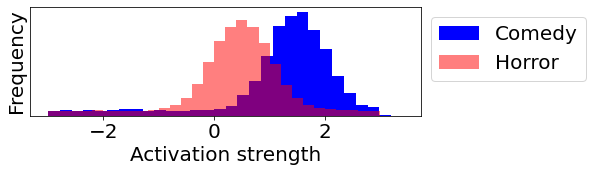

In [39]:
plt.hist(activations[cond_id==0],color='blue',bins=30,label='Comedy')
plt.hist(activations[cond_id==1],color='red',bins=30,alpha=.5,label='Horror')
plt.yticks([]);plt.ylabel('Frequency')
plt.xlabel("Activation strength")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

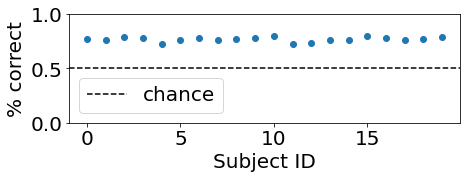

Avg correct predictions across subs: 0.7675
Above-chance prediction accuracy? (t-test):
t=61.7678, p=0.0000


In [32]:
scores=[];
for s in range(num_subjects):
    model = svm.SVC(kernel='linear')

    samples_train = activations[(sub_id==s) & (block_id%2==0)].reshape(-1, 1)
    classes_train = cond_id[(sub_id==s) & (block_id%2==0)].ravel()

    samples_test = activations[(sub_id==s) & (block_id%2==1)].reshape(-1, 1)
    classes_test = cond_id[(sub_id==s) & (block_id%2==1)].ravel()

    model.fit(samples_train,classes_train)
    scores = np.concatenate([scores,[model.score(samples_test,classes_test)]])
plt.scatter(np.arange(len(scores)),scores)
plt.ylim([.0,1.])
plt.ylabel("% correct")
plt.xlabel("Subject ID")
plt.axhline(.5,ls='--',c='k',label='chance')
plt.legend()
plt.show()
print("Avg correct predictions across subs:",np.mean(scores))
stat = sp.stats.ttest_rel(scores,np.ones(num_subjects)*.5)
print("Above-chance prediction accuracy? (t-test):\nt={:.4f}, p={:.4f}".format(stat.statistic,stat.pvalue))

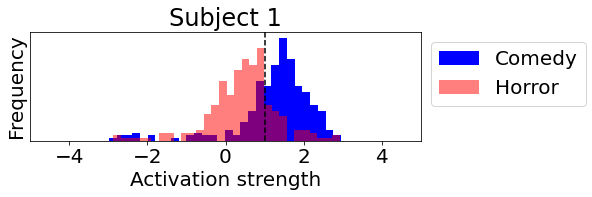

In [42]:
s=0
model = svm.SVC(kernel='linear')
samples_train = activations[(sub_id==s) & (block_id%2==0)].reshape(-1, 1)
classes_train = cond_id[(sub_id==s) & (block_id%2==0)].ravel()
samples_test = activations[(sub_id==s) & (block_id%2==1)].reshape(-1, 1)
classes_test = cond_id[(sub_id==s) & (block_id%2==1)].ravel()
model.fit(samples_train,classes_train)

plt.hist(activations[(sub_id==s) & (block_id%2==1) & (cond_id==0)],color='blue',bins=30,label='Comedy')
plt.hist(activations[(sub_id==s) & (block_id%2==1) & (cond_id==1)],color='red',bins=30,alpha=.5,label='Horror')
plt.yticks([]);plt.ylabel('Frequency')
plt.xlabel("Activation strength")
plt.legend(bbox_to_anchor=(1, 1))

xx = np.linspace(-5, 5, 100)
yy = np.linspace(0, 40, 100)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

plt.title("Subject 1")
plt.contour(XX, YY, Z, colors='k', levels=[0],
            linestyles=['--', '-', '--'])
plt.show()